In [2]:


import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

IMAGE_SIZE=256
BATCH_SIZE=270
CHANNELS=3
EPOCHS=1

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print(class_names)

Found 18163 files belonging to 13 classes.
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


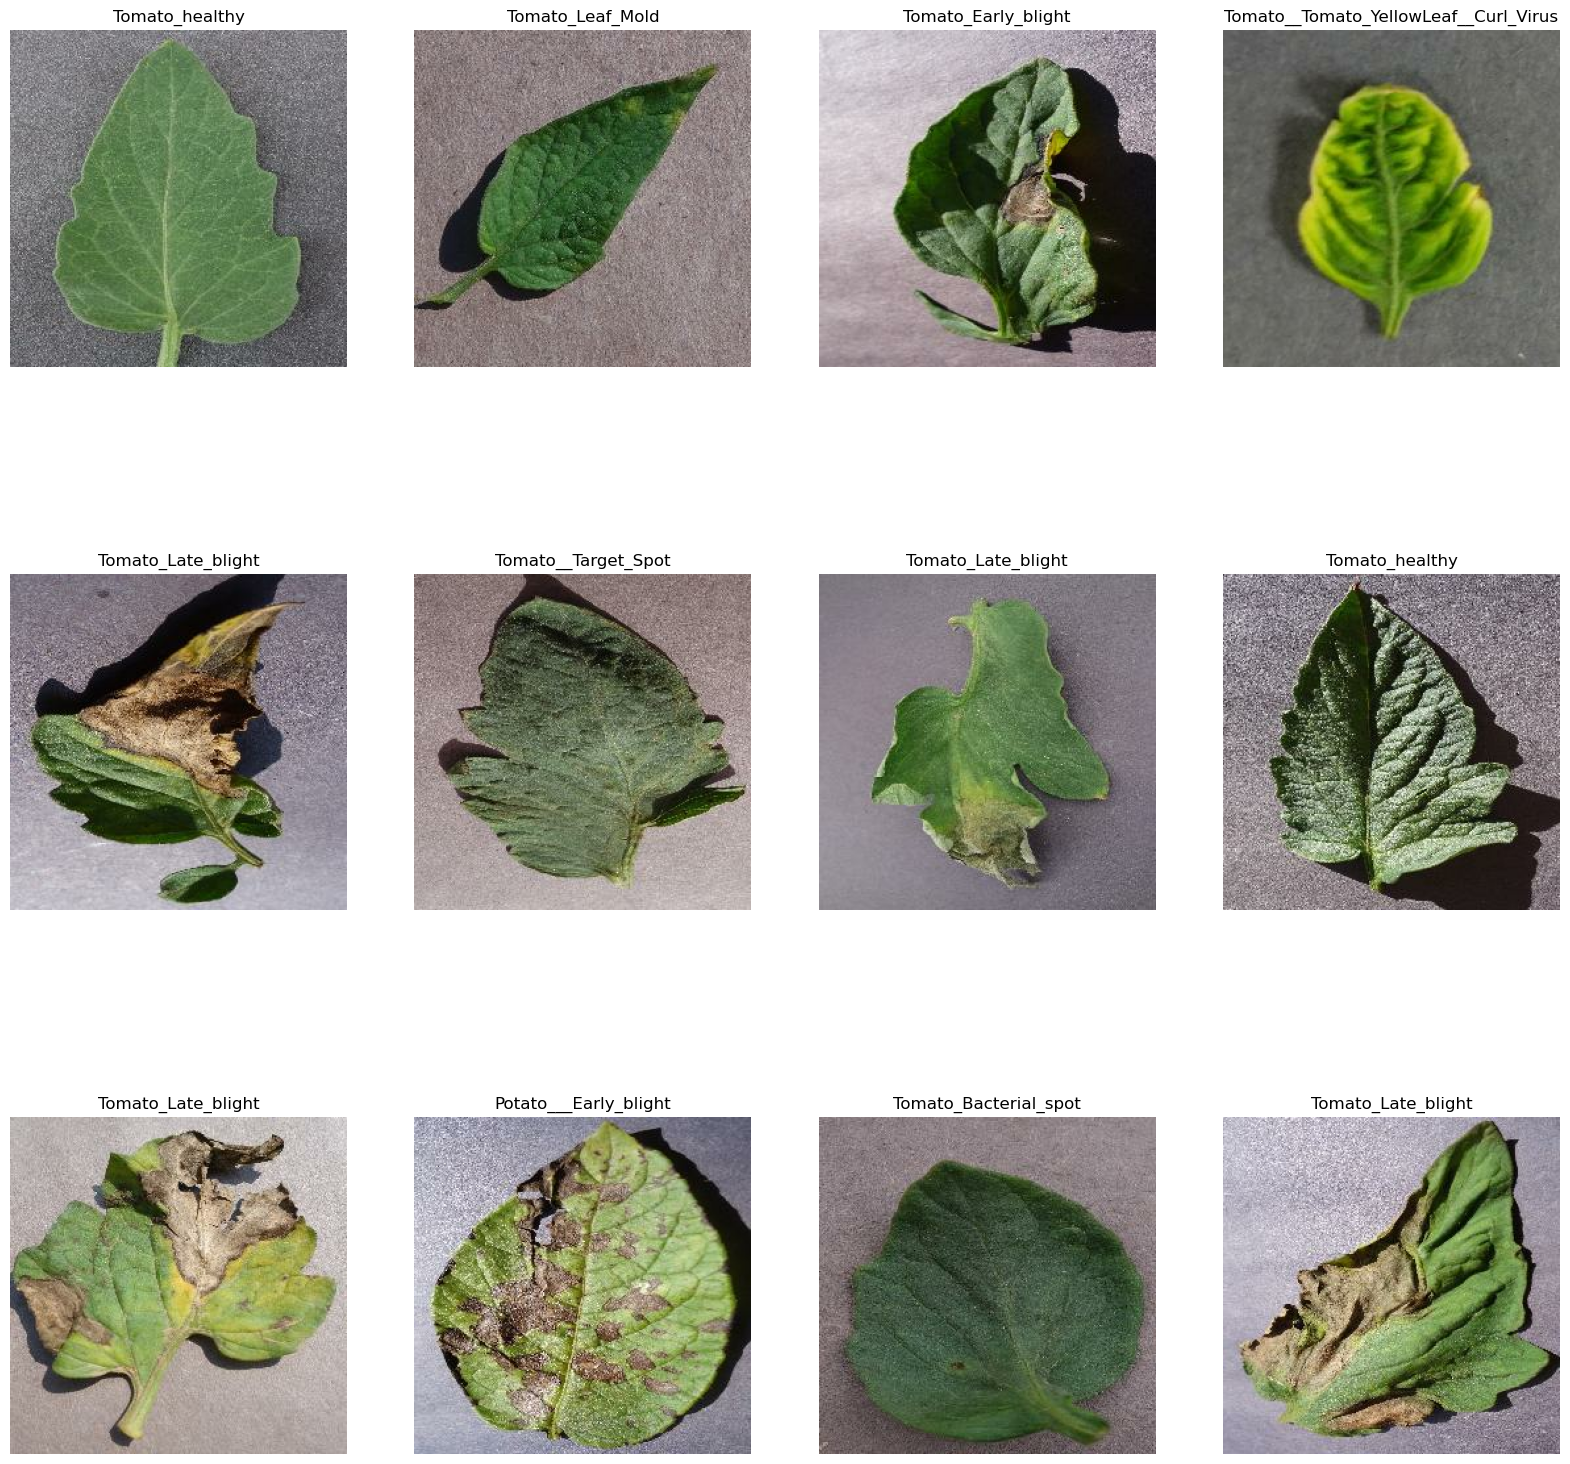

In [3]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [4]:
# Split the data into training, validation, and test sets
train_ds = dataset.take(int(len(dataset) * 0.8))
val_ds = dataset.skip(int(len(dataset) * 0.8)).take(int(len(dataset) * 0.1))
test_ds = dataset.skip(int(len(dataset) * 0.9))


In [ ]:
80% ==> training
20% ==> 10% validation,10% test


In [ ]:
train_ds=dataset.take(454)
len(train_ds)

In [5]:
# Configure the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [6]:
# Define the model
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

In [7]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [ ]:
model.build(input_shape=input_shape)

model.summary()

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

print(history.history)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

for i in range(EPOCHS):
    print(f"Epoch {i+1}/{EPOCHS} - loss: {train_loss[i]:.4f} - accuracy: {train_acc[i]:.4f} - val_loss: {val_loss[i]:.4f} - val_accuracy: {val_acc[i]:.4f}")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (270, 256, 256, 3)        0         
                                                                 
 sequential_1 (Sequential)   (270, 256, 256, 3)        0         
                                                                 
 conv2d (Conv2D)             (270, 254, 254, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (270, 127, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (270, 125, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (270, 62, 62, 64)        0         
 2D)                                                  

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()